In [88]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("auge.csv", delimiter=",", encoding="utf-8")
df.head()

# What does "" means for Group?
df = df[df['Group'].notna() & (df['Group'].astype(str).str.strip() != '')]


In [89]:
# Convert AGE and other numeric columns with potential issues
df['AGE'] = pd.to_numeric(df['AGE'], errors='coerce')
df['OP_DATE'] = pd.to_datetime(df['OP_DATE'], errors='coerce', dayfirst=True)
df['DATE_OF_DEATH'] = pd.to_datetime(df['DATE_OF_DEATH'], errors='coerce', dayfirst=True)
df['Group'] = df['Group'].astype('category')

/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_72988/1930868832.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE_OF_DEATH'] = pd.to_datetime(df['DATE_OF_DEATH'], errors='coerce', dayfirst=True)


/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_72988/1954686980.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = df.groupby('Group')['AGE'].describe()
/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_72988/1954686980.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y='AGE', data=df, palette='Set2')


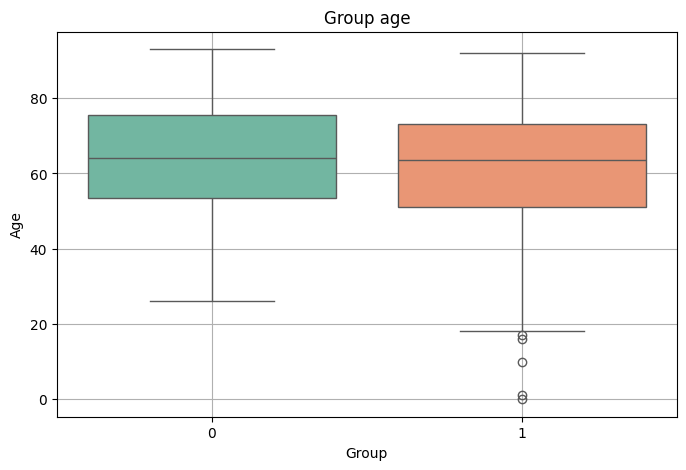

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

age_stats = df.groupby('Group')['AGE'].describe()

plt.figure(figsize=(8, 5))
sns.boxplot(x='Group', y='AGE', data=df, palette='Set2')
plt.title('Group age')
plt.xlabel('Group')
plt.ylabel('Age')
plt.grid(True)
plt.show()


/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_72988/2517849912.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mutation_rate = filtered_df.groupby('Group')['MUTATION'].value_counts(normalize=True).unstack().fillna(0)


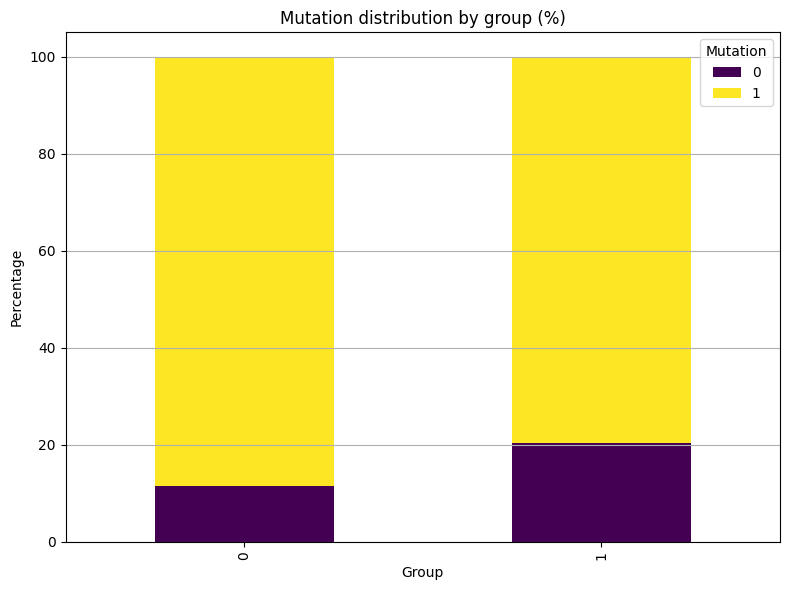

In [91]:
# Filter out rows where MUTATION is -99
filtered_df = df[df['MUTATION'] != -99]

# Now calculate mutation rate per group
mutation_rate = filtered_df.groupby('Group')['MUTATION'].value_counts(normalize=True).unstack().fillna(0)
mutation_rate *= 100

# Plot
mutation_rate.plot(kind='bar', stacked=True, colormap='viridis', figsize=(8, 6))
plt.title('Mutation distribution by group (%)')
plt.ylabel('Percentage')
plt.xlabel('Group')
plt.legend(title='Mutation', loc='upper right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



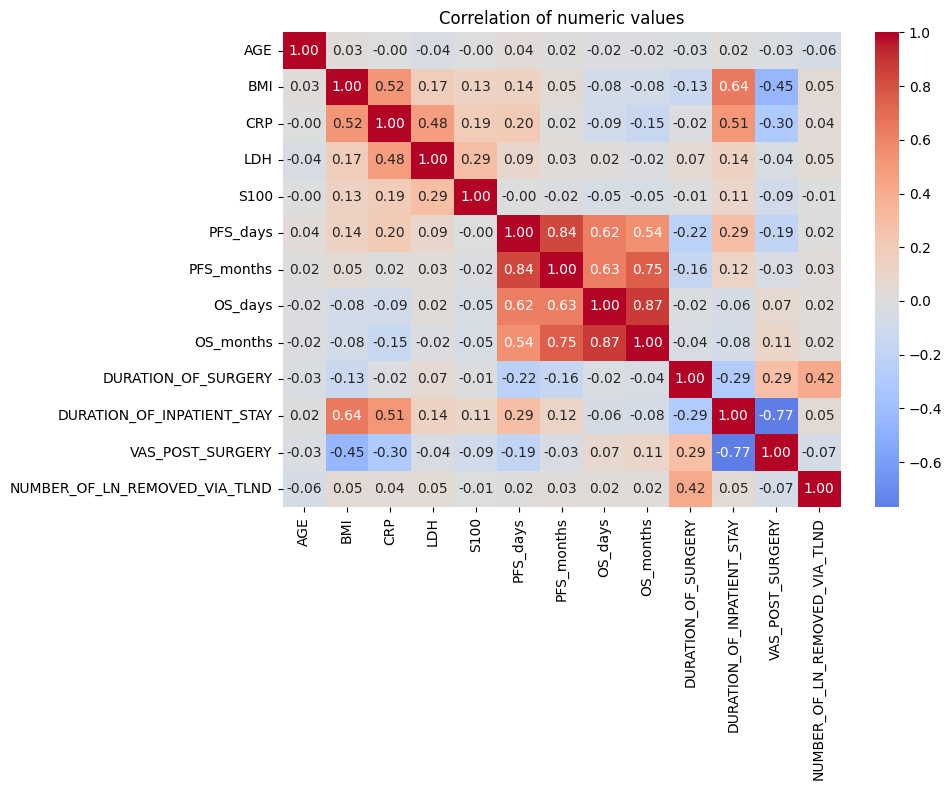

In [92]:
# Select numeric cols
numerical_cols = [
    'AGE', 'BMI', 'CRP', 'LDH', 'S100', 'PFS_days', 'PFS_months',
    'OS_days', 'OS_months', 'DURATION_OF_SURGERY', 'DURATION_OF_INPATIENT_STAY',
    'VAS_POST_SURGERY', 'NUMBER_OF_LN_REMOVED_VIA_TLND'
]

# Choose only valid lines
corr_df = df[numerical_cols].copy()
corr_df = corr_df.apply(pd.to_numeric, errors='coerce')
corr_df.dropna(how='any', inplace=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation of numeric values")
plt.tight_layout()
plt.show()



/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_72988/3315791361.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=valid_os, x='Group', y='OS_months', palette='Set3', inner='box')


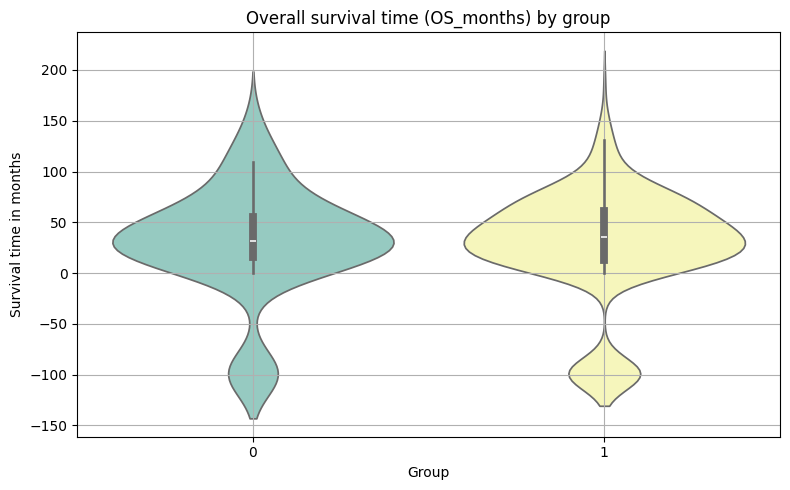

In [98]:
valid_os = df[df['OS_months'].notna() & df['Group'].notna()]

plt.figure(figsize=(8, 5))
sns.violinplot(data=valid_os, x='Group', y='OS_months', palette='Set3', inner='box')
plt.title('Overall survival time (OS_months) by group')
plt.xlabel('Group')
plt.ylabel('Survival time in months')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_72988/3130923394.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='MUTATION', y='BMI', ax=axes[0], palette='pastel')
/var/folders/hf/7wdcz5y51yv6bqwk5y7ck5f00000gn/T/ipykernel_72988/3130923394.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='MUTATION', y='CRP', ax=axes[1], palette='pastel')


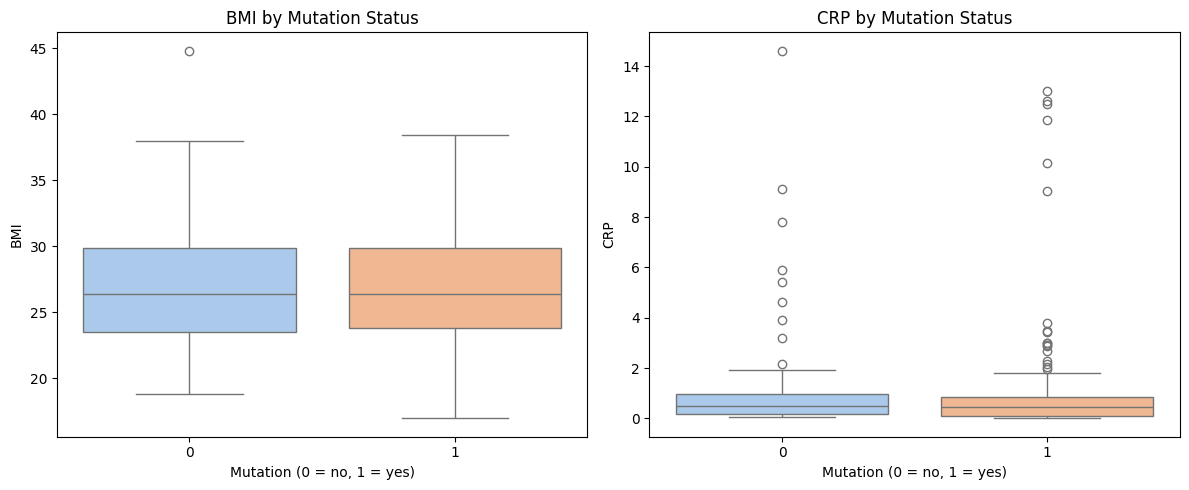

In [94]:
# Filter MUTATION to 0 and 1
subset = df[df['MUTATION'].isin([0, 1])]

# Filter out invalid values (-99) from BMI and CRP
subset = subset[(subset['BMI'] != -99) & (subset['CRP'] != -99)]

# Drop any NaNs
subset = subset[['MUTATION', 'BMI', 'CRP']].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=subset, x='MUTATION', y='BMI', ax=axes[0], palette='pastel')
axes[0].set_title('BMI by Mutation Status')
axes[0].set_xlabel('Mutation (0 = no, 1 = yes)')

sns.boxplot(data=subset, x='MUTATION', y='CRP', ax=axes[1], palette='pastel')
axes[1].set_title('CRP by Mutation Status')
axes[1].set_xlabel('Mutation (0 = no, 1 = yes)')

plt.tight_layout()
plt.show()


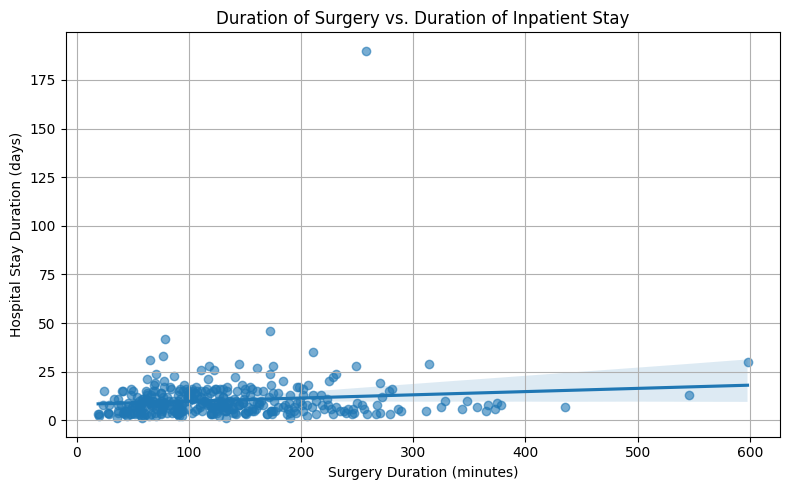

In [95]:
subset = df[
    (df['DURATION_OF_SURGERY'] != -99) &
    (df['DURATION_OF_INPATIENT_STAY'] != -99) &
    df['DURATION_OF_SURGERY'].notna() &
    df['DURATION_OF_INPATIENT_STAY'].notna()
][['DURATION_OF_SURGERY', 'DURATION_OF_INPATIENT_STAY']]

plt.figure(figsize=(8, 5))
sns.regplot(data=subset, x='DURATION_OF_SURGERY', y='DURATION_OF_INPATIENT_STAY', scatter_kws={'alpha': 0.6})
plt.title("Duration of Surgery vs. Duration of Inpatient Stay")
plt.xlabel("Surgery Duration (minutes)")
plt.ylabel("Hospital Stay Duration (days)")
plt.grid(True)
plt.tight_layout()
plt.show()


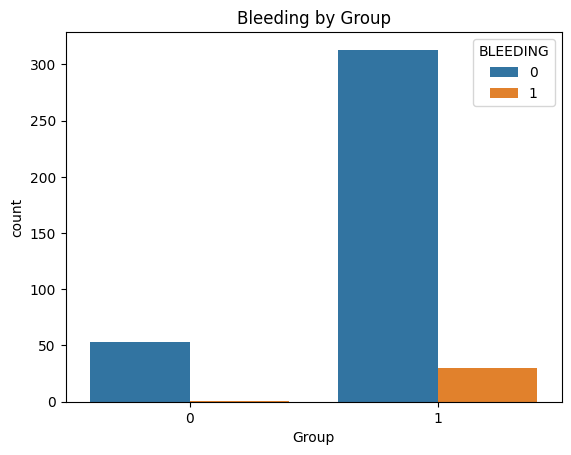

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out invalid -99 BLEEDING values
filtered_df = df[df['BLEEDING'] != -99]

# Barplot of Bleeding by Group
sns.countplot(data=filtered_df, x='Group', hue='BLEEDING')
plt.title("Bleeding by Group")
plt.show()


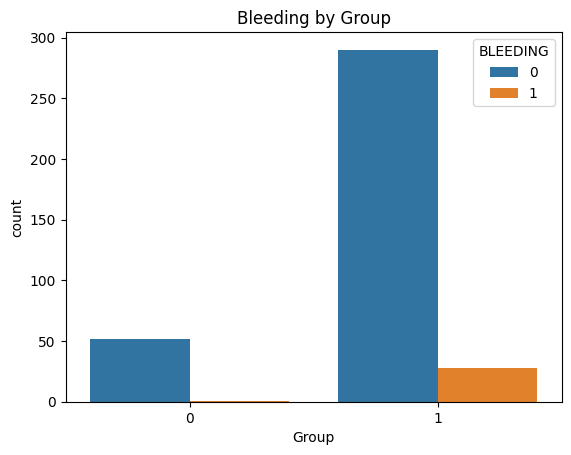

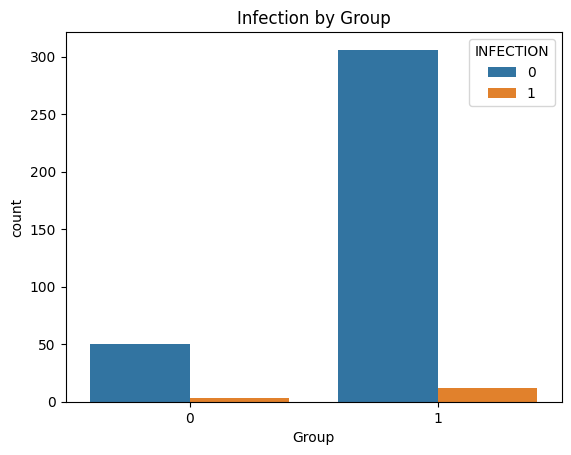

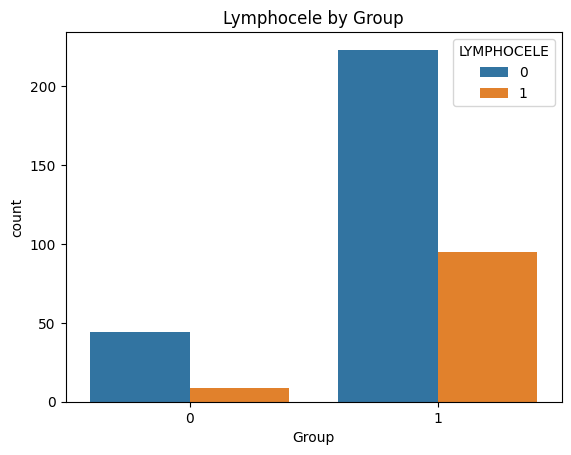

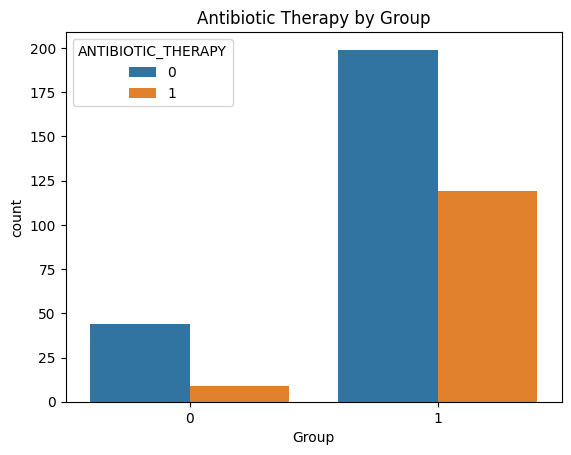

In [97]:
complications = ['BLEEDING', 'INFECTION', 'LYMPHOCELE', 'ANTIBIOTIC_THERAPY']

for comp in complications:
    filtered_df = df[
        (df['BLEEDING'] != -99) &
        (df['ANTIBIOTIC_THERAPY'] != -99)
    ]
    
    sns.countplot(data=filtered_df, x='Group', hue=comp)
    plt.title(f"{comp.replace('_', ' ').title()} by Group")
    plt.show()
